Load all the necessary modules here:

In [64]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV


Load the data set:

In [20]:
data_frame = pd.read_excel("../dataset/insurance_claims_data.xlsx")

data_frame.head()
data_frame.columns
print(len(data_frame.columns))

39


Let's understand the dataset:

In [21]:
data_frame.describe()

,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,203.954000,38.948000,546238.648000,1136.000000,1256.406150,1.101000e+06,501214.488000,25126.100000,-26793.700000,11.644000,1.83900,0.992000,1.487000,52761.94000,7433.420000,7399.570000,37928.950000,2005.103000
std,115.113174,9.140287,257063.005276,611.864673,244.167395,2.297407e+06,71701.610941,27872.187708,28104.096686,6.951373,1.01888,0.820127,1.111335,26401.53319,4880.951853,4824.726179,18886.252893,6.015861
min,0.000000,19.000000,100804.000000,500.000000,433.330000,-1.000000e+06,430104.000000,0.000000,-111100.000000,0.000000,1.00000,0.000000,0.000000,100.00000,0.000000,0.000000,70.000000,1995.000000
25%,115.750000,32.000000,335980.250000,500.000000,1089.607500,0.000000e+00,448404.500000,0.000000,-51500.000000,6.000000,1.00000,0.000000,1.000000,41812.50000,4295.000000,4445.000000,30292.500000,2000.000000
50%,199.500000,38.000000,533135.000000,1000.000000,1257.200000,0.000000e+00,466445.500000,0.000000,-23250.000000,12.000000,1.00000,1.000000,1.000000,58055.00000,6775.000000,6750.000000,42100.000000,2005.000000
75%,276.250000,44.000000,759099.750000,2000.000000,1415.695000,0.000000e+00,603251.000000,51025.000000,0.000000,17.000000,3.00000,2.000000,2.000000,70592.50000,11305.000000,10885.000000,50822.500000,2010.000000
max,479.000000,64.000000,999435.000000,2000.000000,2047.590000,1.000000e+07,620962.000000,100500.000000,0.000000,23.000000,4.00000,2.000000,3.000000,114920.00000,21450.000000,23670.000000,79560.000000,2015.000000


Now that we have looked at the meta data. Let's clean this data and encode it to make it suitable for training a DecisionTreeClassifier.
My approach to normalize this data is:
- Drop all null valued data points.
- Convert features with type of timestamp into a meaning full categorical feature.
- Encode every categorical feature to make it Training ready.
- Reduce the variance for features to the maximum extend possible.

In [22]:
#Let's begin with removing all the rows that have null/no values in them
data_frame = data_frame.dropna()

In [23]:
print(data_frame.describe())
#this would give us all continous features.

       months_as_customer          age  policy_number  policy_deductable  \
count         1000.000000  1000.000000    1000.000000        1000.000000   
mean           203.954000    38.948000  546238.648000        1136.000000   
std            115.113174     9.140287  257063.005276         611.864673   
min              0.000000    19.000000  100804.000000         500.000000   
25%            115.750000    32.000000  335980.250000         500.000000   
50%            199.500000    38.000000  533135.000000        1000.000000   
75%            276.250000    44.000000  759099.750000        2000.000000   
max            479.000000    64.000000  999435.000000        2000.000000   

       policy_annual_premium  umbrella_limit    insured_zip  capital-gains  \
count            1000.000000    1.000000e+03    1000.000000    1000.000000   
mean             1256.406150    1.101000e+06  501214.488000   25126.100000   
std               244.167395    2.297407e+06   71701.610941   27872.187708   
min

In [24]:
#lets see which features are categorical:

categorical_features = data_frame.select_dtypes(include=['object', 'category'])
categorical_features.columns
print(len(categorical_features.columns))

19


- All the columns that were returned within the variable categorical_features, are to be encoded.
- Lets perfom some encoding for better fitting.
- Lets use OneHotEncoder for these categorical features.

In [25]:

X = data_frame.drop(columns=["fraud_reported"])
y = data_frame["fraud_reported"]

#I will re extract the featues that should be encoded.
string_features = X.select_dtypes(include="object").columns

#converting these to strings
X[string_features] = X[string_features].astype(str)

#lets encode
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(X[string_features])

#getting feature names and encoder categories
categories = encoder.categories_
feature_names = []
for i, category in enumerate(categories):
    names = [f"{string_features[i]}_{value}" for value in category]
    feature_names.extend(names)

X_encoded = pd.DataFrame(encoded_data, columns=feature_names)

# Concatenate input features and target variable
data_encoded = pd.concat([X_encoded, y], axis=1)

# Drop rows with missing values
data_encoded = data_encoded.dropna()

Let's create train and test sets!


In [26]:
X.columns = X.columns.astype(str)
X = data_encoded.drop(columns=["fraud_reported"])
print(X.head())
y = data_encoded["fraud_reported"]
y =y.replace('N', 0)
y = y.replace('Y', 1)
X_train, X_test, y_train , y_test = train_test_split(X, y, test_size=0.3, random_state=42)

   policy_state_IL  policy_state_IN  policy_state_OH  policy_csl_100/300  \
0              0.0              0.0              1.0                 0.0   
1              0.0              1.0              0.0                 0.0   
2              0.0              0.0              1.0                 1.0   
3              1.0              0.0              0.0                 0.0   
4              1.0              0.0              0.0                 0.0   

   policy_csl_250/500  policy_csl_500/1000  insured_sex_FEMALE  \
0                 1.0                  0.0                 0.0   
1                 1.0                  0.0                 0.0   
2                 0.0                  0.0                 1.0   
3                 1.0                  0.0                 1.0   
4                 0.0                  1.0                 0.0   

   insured_sex_MALE  insured_education_level_Associate  \
0               1.0                                0.0   
1               1.0           

Let's define a strawman baseline model! My baseline model would be base on majority class since this is a classification task, I'll define it within a method!

In [27]:
def majority_class_baseline(X_train, y_train, X_test):
    """
    Implements a strawman majority class baseline model for binary classification.
"""
    # Count the number of instances of each class in the training data
    class_counts = np.bincount(y_train)
    majority_class = np.argmax(class_counts)

    # Predict the majority class for all instances in the testing data
    y_pred = np.full((X_test.shape[0],), majority_class)

    return y_pred


In [28]:
print(classification_report(y_test, majority_class_baseline(X_train, y_train, X_test)))

              precision    recall  f1-score   support

           0       0.73      1.00      0.85       220
           1       0.00      0.00      0.00        80

    accuracy                           0.73       300
   macro avg       0.37      0.50      0.42       300
weighted avg       0.54      0.73      0.62       300



c:\Users\Sanju\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Sanju\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Sanju\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

That's very Surprising! we got an accuracy of 0.73! This however I personally feel because we have lesser data. And also this is by Concidence!

Let's define some methods that can be used to make reports

In [39]:
def plot_confusion_matrix(y_true, y_pred):
    labels = np.unique(y_true)  # Get the unique labels
    cm = confusion_matrix(y_true, y_pred, labels=labels)  # Compute the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))  # Create a figure and an axis object
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)  # Plot the confusion matrix as a heatmap
    ax.set_xlabel('Predicted Label') 
    ax.set_ylabel('True Label')  
    ax.set_title('Confusion Matrix')  
    plt.show()  


Lets define a method that can make predictions based on user given threshold:

In [46]:
import numpy as np

def threshold_prediction(y_pred_proba, threshold):
    y_pred = list()
    for values in y_pred_proba:
        if values[1]>= threshold:
            y_pred.append(1)
        else:
            y_pred.append(0)
    return y_pred


Let's define a method to plot an ROC-AUC curve for each model:

In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_auc(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) curve')
    plt.legend(loc="lower right")
    plt.show()


Now that we defined our datasets, I want to train the following models to outperform my baseline model:

- Logistic Regression
- DecisionTreeClassifier
- SVM
- NaiveBayesClassifier

Let's start with NaiveBayes Multinomial model:

In [31]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
nb

MultinomialNB()

In [32]:
y_pred = nb.predict(X_test)
y_pred_proba = nb.predict_proba(X_test)

In [36]:
#lets get the metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.98      0.85       220
           1       0.56      0.06      0.11        80

    accuracy                           0.74       300
   macro avg       0.65      0.52      0.48       300
weighted avg       0.69      0.74      0.65       300



Let's see the confusion matrix:

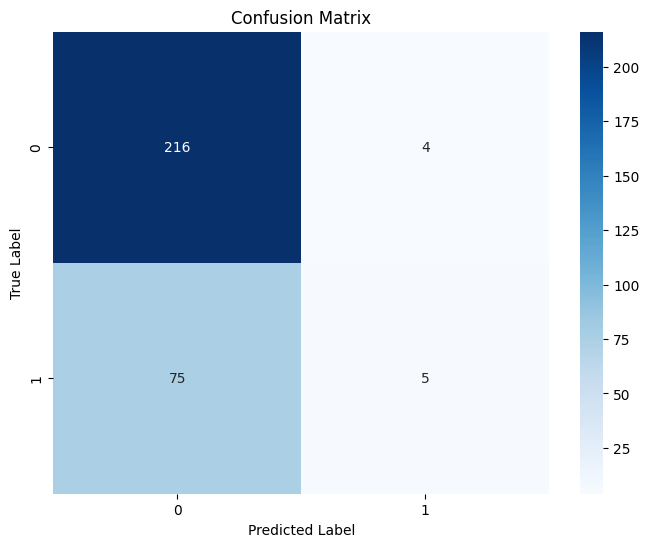

In [40]:
plot_confusion_matrix(y_test, y_pred)

As we can see most of the claims have not been identified! this is because we have a lot more claims which are not fraudualent!

In [67]:
y_pred = threshold_prediction(y_pred_proba, 0.065)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.85      0.78      0.82       220
           1       0.51      0.62      0.56        80

    accuracy                           0.74       300
   macro avg       0.68      0.70      0.69       300
weighted avg       0.76      0.74      0.75       300



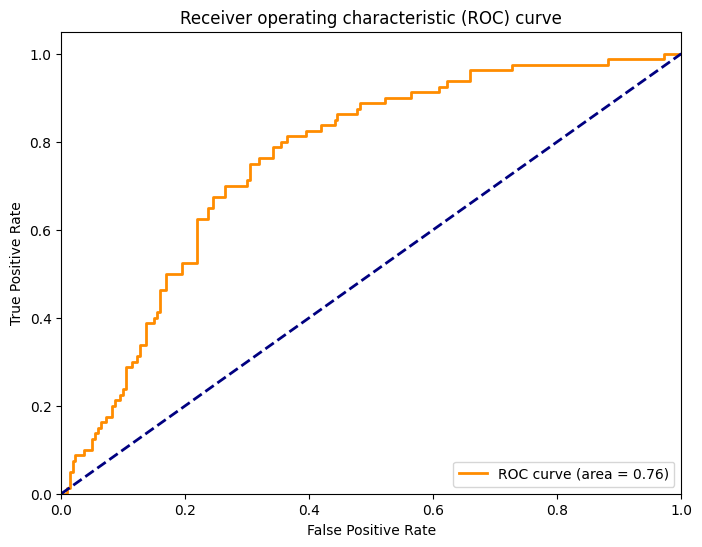

In [63]:
plot_roc_auc(y_test, y_pred_proba[:,1])

Let's find the best Hyperparams for this Naivebayes model:

In [73]:
param_grid = {
    'alpha': [0.05, 0.1, 0.5, 1.0, 2.0, 2.5],
    'fit_prior': [True, False],
}
grid_search = GridSearchCV(nb, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and their corresponding F1 score
print("Best hyperparameters:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)

# Evaluate the model using the best hyperparameters on the testing set
nb_model_best = MultinomialNB(alpha=grid_search.best_params_['alpha'], 
                              fit_prior=grid_search.best_params_['fit_prior'])
nb_model_best.fit(X_train, y_train)
y_pred = nb_model_best.predict(X_test)
y_pred_proba = nb_model_best.predict_proba(X_test)

# Print the evaluation metrics on the testing set
print(classification_report(y_test, y_pred))

Best hyperparameters: {'alpha': 0.1, 'fit_prior': True}
Best F1 score: 0.7260785699476141
              precision    recall  f1-score   support

           0       0.85      0.75      0.80       220
           1       0.49      0.64      0.55        80

    accuracy                           0.72       300
   macro avg       0.67      0.70      0.68       300
weighted avg       0.75      0.72      0.73       300



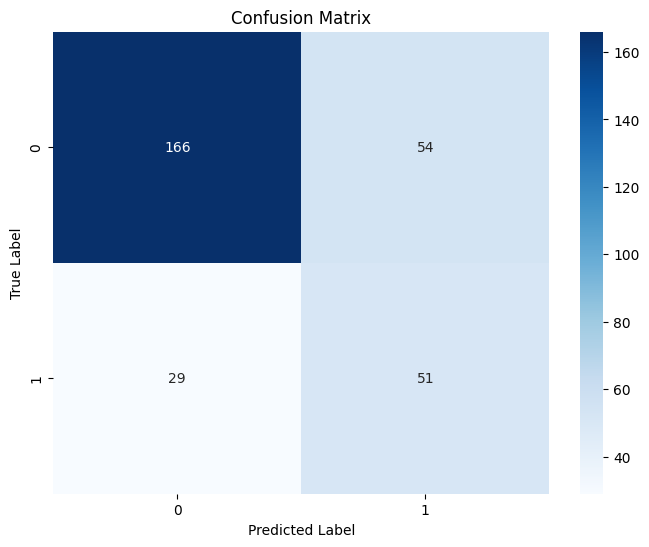

In [74]:
#lets plot an roc AUC curve for this:
plot_confusion_matrix(y_test, y_pred)

This is a significant improvement! From the previous classification performed!

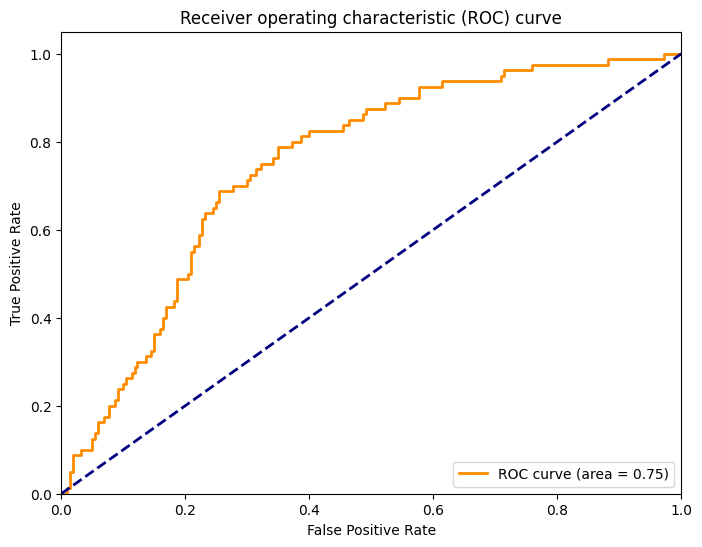

In [76]:
plot_roc_auc(y_test, y_pred_proba[:,1])

We a stable working model!